<a href="https://colab.research.google.com/github/rodrigorenemenegazzo/Artificial-Intelligence/blob/main/Keras_RaioXCao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [2]:
# -*- coding: utf-8 -*-

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Filter out corrupted images
import os

num_skipped = 0
for folder_name in ("naoproblema", "problema"):
    folder_path = os.path.join("/content/gdrive/MyDrive/Especializacao IA UFPR/TCC/imagensrodrigo", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


In [3]:
#Generate a Dataset

image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Especializacao IA UFPR/TCC/imagensrodrigo",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/Especializacao IA UFPR/TCC/imagensrodrigo",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 77 files belonging to 2 classes.
Using 62 files for training.
Found 77 files belonging to 2 classes.
Using 15 files for validation.


Epoch 1/50
2/2 [==============================] - 26s 11s/step - loss: 0.8543 - accuracy: 0.4677 - val_loss: 0.6932 - val_accuracy: 0.5333
Epoch 2/50
2/2 [==============================] - 19s 9s/step - loss: 0.7615 - accuracy: 0.5968 - val_loss: 0.6930 - val_accuracy: 0.5333
Epoch 3/50
2/2 [==============================] - 19s 9s/step - loss: 0.5987 - accuracy: 0.7258 - val_loss: 0.6930 - val_accuracy: 0.5333
Epoch 4/50
2/2 [==============================] - 19s 9s/step - loss: 0.6223 - accuracy: 0.7581 - val_loss: 0.6929 - val_accuracy: 0.5333
Epoch 5/50
2/2 [==============================] - 19s 9s/step - loss: 0.4876 - accuracy: 0.7419 - val_loss: 0.6928 - val_accuracy: 0.5333
Epoch 6/50
2/2 [==============================] - 19s 9s/step - loss: 0.4589 - accuracy: 0.7419 - val_loss: 0.6926 - val_accuracy: 0.5333
Epoch 7/50
2/2 [==============================] - 19s 9s/step - loss: 0.4566 - accuracy: 0.8065 - val_loss: 0.6923 - val_accuracy: 0.5333
Epoch 8/50
2/2 [=================

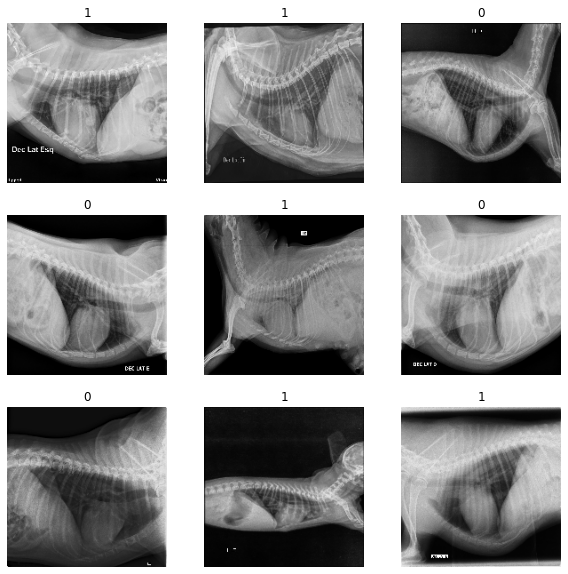

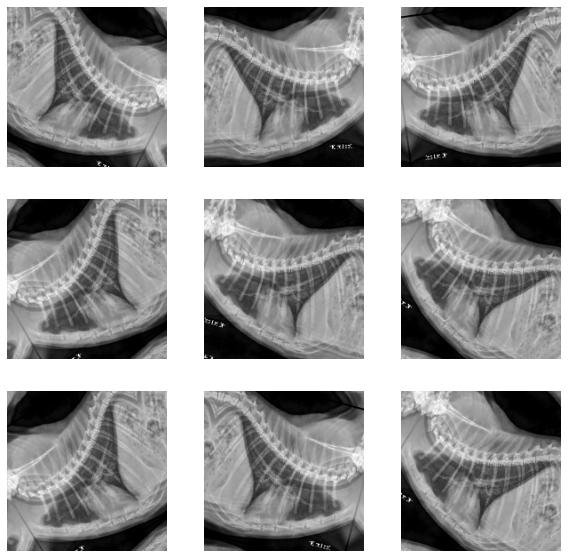

In [4]:
#Visualize the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
        
        
# Augmentation        
# Using image data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Let's visualize what the augmented samples look like, by applying 
#data_augmentation repeatedly to the first image in the dataset:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the data

# data_augmentation preprocessor the data If you're training on CPU
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))


# Configure the dataset for performance
# Let's make sure to use buffered prefetching so we can yield 
#data from disk without having I/O becoming blocking:

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


# Build a model
#We start the model with the data_augmentation preprocessor, followed by 
#a Rescaling layer.
#We include a Dropout layer before the final classification layer.

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)



# Train the model

epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

This image is 28.12 percent Negative and 71.88 percent Positivo.


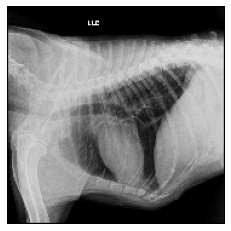

In [16]:

# Run inference on new data
# Using the model to predict

img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/Especializacao IA UFPR/TCC/imagensrodrigo/naoproblema.jpg", target_size=image_size
)

###show image
plt.imshow(img)
plt.axis("off")
#####

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

print(
    "This image is %.2f percent Negative and %.2f percent Positivo."
    % (100 * (1 - score), 100 * score)
)
